
Rosenbrock: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rosenbrock'
n_test = 500
eps = 1e-08

util = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3
cov_func = squaredExponential()


In [4]:
### Objective function:

if func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def objfunc(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Acquisition function:

Beta_CBM = dim

class Acquisition(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]
    
    def CBM(self, y_global_orig, mean, std, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        return f

    def eval(self, y_global_orig, mean, std, nu=3.0):
    
        return self.f(y_global_orig, mean, std, nu=3.0, **self.params)
        

In [8]:
## GPGO_multi: 

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):
    
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [9]:
###Reproducible set-seeds:

run_num_9 = 9


***Explanation:*** Why does optimising negative EI with exact (negative) EI gradients, outperform approximate (negative) EI gradients for (negative) EI optimisation?


1. Considering the best (**x**, *y*) point sampled by the exact (negative) EI gradients' model



In [10]:
### ESTIMATED GP CBM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=opt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition(util), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1  	 [ 1.44056489 -0.0133713 ]	 436.4184610888146	 132.4681822844375	 -137.86420146797667


In [11]:
### ESTIMATED STP CBM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = GPGO_multi(surrogate_stp_9, Acquisition(util), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1	 [0.87795003 0.23986924]	 28.203244972728623	 28.203244972728623	 -1231.873294450015


In [12]:
gp_9.start_points_arr


array([[ 1.2441181 ,  1.97983948],
       [-1.35316989,  0.08636298],
       [ 1.82483934,  0.61251774],
       [ 1.47796756,  1.92858527],
       [-1.28802125, -1.05219819],
       [ 1.52944985,  1.66411173],
       [ 1.05790663, -0.6270896 ],
       [-0.14936181,  0.45276259],
       [-0.01523008, -0.09021844],
       [-0.26396482,  1.51719238],
       [-1.28057898,  0.76871309],
       [ 0.8336555 ,  1.74161952],
       [-1.88639307,  0.60259006],
       [ 0.56546912, -0.15688637],
       [-1.8306686 , -1.8900135 ],
       [-1.35359933,  1.20646815],
       [-1.38196563, -1.47972629],
       [-0.60245216, -0.06349433],
       [ 0.80992823,  1.23353674],
       [-0.95529215,  1.67721455]])

In [13]:
stp_9.start_points_arr


array([[ 1.2441181 ,  1.97983948],
       [-1.35316989,  0.08636298],
       [ 1.82483934,  0.61251774],
       [ 1.47796756,  1.92858527],
       [-1.28802125, -1.05219819],
       [ 1.52944985,  1.66411173],
       [ 1.05790663, -0.6270896 ],
       [-0.14936181,  0.45276259],
       [-0.01523008, -0.09021844],
       [-0.26396482,  1.51719238],
       [-1.28057898,  0.76871309],
       [ 0.8336555 ,  1.74161952],
       [-1.88639307,  0.60259006],
       [ 0.56546912, -0.15688637],
       [-1.8306686 , -1.8900135 ],
       [-1.35359933,  1.20646815],
       [-1.38196563, -1.47972629],
       [-0.60245216, -0.06349433],
       [ 0.80992823,  1.23353674],
       [-0.95529215,  1.67721455]])

In [14]:
np.sum((stp_9.start_points_arr - gp_9.start_points_arr)**2)


0.0

In [15]:
np.round(gp_9.f_best, 5), np.argmin(gp_9.f_best)


(array([-137.8642 , -137.8642 , -137.8642 , -137.8642 , -130.99186,
        -137.8642 , -137.8642 , -137.8642 , -137.8642 , -137.8642 ,
        -137.8642 , -137.8642 , -137.8642 , -137.8642 ,  202.91847,
        -137.8642 , -130.99186, -137.8642 , -137.8642 , -137.8642 ]), 8)

In [16]:
min(gp_9.f_best), np.round(max(gp_9.f_best), 4)


(-137.86420146797667, 202.9185)

In [17]:
gp_9.x_best[np.argmin(gp_9.f_best)], gp_9.best


(array([ 1.44056489, -0.0133713 ]), array([ 1.44056489, -0.0133713 ]))

In [18]:
np.round(stp_9.f_best, 5), np.argmin(stp_9.f_best)


(array([-1231.87329, -1231.87329, -1231.87329, -1231.87329, -1145.32645,
        -1231.87329, -1231.87329, -1231.87329, -1231.87329, -1231.87329,
        -1231.87329, -1231.87329, -1231.87329, -1231.87329,  -423.15988,
        -1231.87329, -1145.32645, -1231.87329, -1231.87329, -1231.87329]), 2)

In [19]:
min(stp_9.f_best), np.round(max(stp_9.f_best), 4)


(-1231.873294450015, -423.1599)

In [20]:
stp_9.x_best[np.argmin(stp_9.f_best)], stp_9.best


(array([0.87795003, 0.23986924]), array([0.87795003, 0.23986924]))

In [21]:
np.sum((stp_9.f_best - gp_9.f_best)**2)


22796273.647170834

In [22]:
stp_9.x_best


array([[ 0.87794979,  0.23986977],
       [ 0.87794993,  0.23986781],
       [ 0.87795003,  0.23986924],
       [ 0.87795002,  0.2398695 ],
       [ 2.048     , -2.048     ],
       [ 0.87792756,  0.23996019],
       [ 0.87795005,  0.23986922],
       [ 0.8779457 ,  0.23986671],
       [ 0.87794967,  0.23986845],
       [ 0.87794939,  0.23987109],
       [ 0.87795073,  0.23986962],
       [ 0.87794524,  0.23986865],
       [ 0.87794967,  0.23986958],
       [ 0.87794991,  0.23986831],
       [-2.048     , -2.048     ],
       [ 0.87795001,  0.23986919],
       [ 2.048     , -2.048     ],
       [ 0.87795006,  0.23986925],
       [ 0.87795448,  0.23987865],
       [ 0.8779727 ,  0.23985109]])

In [23]:
np.sum((stp_9.x_best - stp_9.start_points_arr)**2)


74.71131634495973

In [24]:
gp_9.x_best


array([[ 1.44056668, -0.01337125],
       [ 1.4405642 , -0.01337072],
       [ 1.44056456, -0.01337346],
       [ 1.44056349, -0.0133654 ],
       [ 2.048     , -2.048     ],
       [ 1.4405647 , -0.01337147],
       [ 1.44056437, -0.01337179],
       [ 1.44056425, -0.01337037],
       [ 1.44056489, -0.0133713 ],
       [ 1.44056543, -0.01336865],
       [ 1.44056879, -0.01338374],
       [ 1.44055994, -0.01335041],
       [ 1.4405804 , -0.01340209],
       [ 1.44055429, -0.01338371],
       [-2.048     , -2.048     ],
       [ 1.4405647 , -0.01337367],
       [ 2.048     , -2.048     ],
       [ 1.44056157, -0.01337148],
       [ 1.44056492, -0.0133712 ],
       [ 1.44056842, -0.01337625]])

In [25]:
np.sum((gp_9.x_best - gp_9.start_points_arr)**2)


101.60381421621139

In [26]:
np.sum((stp_9.x_best - gp_9.x_best)**2)


6.471393128033393

In [27]:
a = gp_9.best[0]
b = gp_9.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


436.4184610888146

In [28]:
a = stp_9.best[0]
b = stp_9.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


28.203244972728623

In [29]:
xBest0 = 0.0898
xBest1 = -0.7126

xBest = [xBest0, xBest1]
xBest


[0.0898, -0.7126]

In [30]:
def check(x):
  a = x[:,0]
  b = x[:,1] 
  for i in range(0, len(a) - 1):
    res = (a - xBest0)**2 + (b - xBest1)**2 
    return np.sum(res)

check(gp_9.x_best), check(stp_9.x_best)


(56.91839229410021, 43.57173309965359)

In [31]:
np.std(gp_9.x_best), np.std(stp_9.x_best)


(1.1211688574978484, 0.9177697793921277)

In [32]:
np.mean(gp_9.x_best), np.mean(stp_9.x_best)


(0.5041564658601132, 0.37267503198556584)

In [33]:
gp_9_20rms = pd.Series(np.round(gp_9.f_best, 2)).value_counts(sort=True)
gp_9_20rms_df = pd.DataFrame({'Frequency':gp_9_20rms.values,'GP CBM':gp_9_20rms.index})
gp_9_20rms_df


,Frequency,GP CBM
0,17,-137.86
1,2,-130.99
2,1,202.92


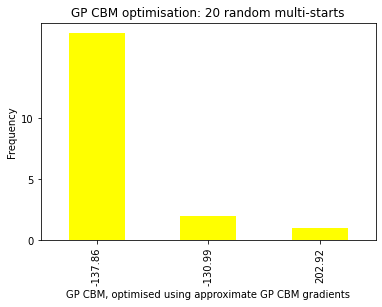

In [34]:
ax = gp_9_20rms.plot.bar(title="GP CBM optimisation: 20 random multi-starts", xlabel="GP CBM, optimised using approximate GP CBM gradients", ylabel="Frequency", color="yellow", yticks=[0,5,10])


In [35]:
stp_9_20rms = pd.Series(np.round(stp_9.f_best, 2)).value_counts(sort=True)
stp_9_20rms_df = pd.DataFrame({'Frequency':stp_9_20rms.values,'STP CBM':stp_9_20rms.index})
stp_9_20rms_df


,Frequency,STP CBM
0,17,-1231.87
1,2,-1145.33
2,1,-423.16


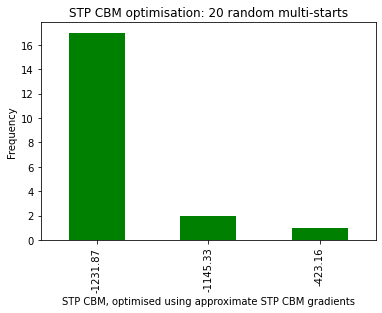

In [36]:
ax = stp_9_20rms.plot.bar(title="STP CBM optimisation: 20 random multi-starts", xlabel="STP CBM, optimised using approximate STP CBM gradients", ylabel="Frequency", color="green")


In [37]:
n_start = 50


In [38]:
### ESTIMATED GP CBM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_9)
surrogate_gp_9_50rms = GaussianProcess(cov_func, optimize=opt)

gp_9_50rms = GPGO_multi(surrogate_gp_9_50rms, Acquisition(util), objfunc, param)
gp_9_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1  	 [ 1.44056489 -0.0133713 ]	 436.4184610888146	 132.4681822844375	 -137.86420146797667


In [39]:
### ESTIMATED STP CBM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_9)
surrogate_stp_9_50rms = tStudentProcess(cov_func, optimize=opt, nu = df)

stp_9_50rms = GPGO_multi(surrogate_stp_9_50rms, Acquisition(util), objfunc, param)
stp_9_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1	 [0.87795    0.23986923]	 28.20324115403495	 28.20324115403495	 -1231.8732944500152


In [40]:
gp_9_50rms = pd.Series(np.round(gp_9_50rms.f_best, 2)).value_counts(sort=True)
gp_9_50rms_df = pd.DataFrame({'Frequency':gp_9_50rms.values,'GP CBM':gp_9_50rms.index})
gp_9_50rms_df


,Frequency,GP CBM
0,38,-137.86
1,10,-130.99
2,2,202.92


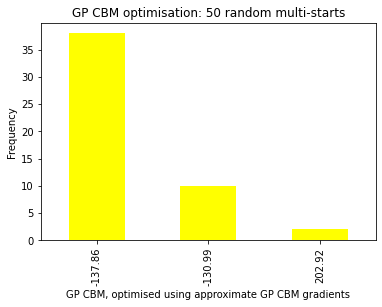

In [41]:
ax = gp_9_50rms.plot.bar(title="GP CBM optimisation: 50 random multi-starts", xlabel="GP CBM, optimised using approximate GP CBM gradients", ylabel="Frequency", color="yellow")


In [42]:
stp_9_50rms = pd.Series(np.round(stp_9_50rms.f_best, 2)).value_counts(sort=True)
stp_9_50rms_df = pd.DataFrame({'Frequency':stp_9_50rms.values,'STP CBM':stp_9_50rms.index})
stp_9_50rms_df


,Frequency,STP CBM
0,43,-1231.87
1,5,-1145.33
2,2,-423.16


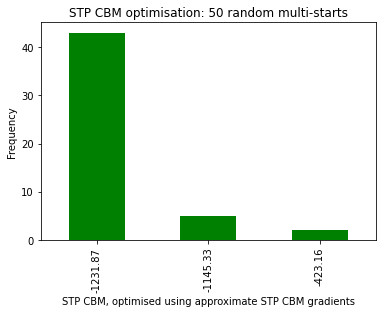

In [43]:
ax = stp_9_50rms.plot.bar(title="STP CBM optimisation: 50 random multi-starts", xlabel="STP CBM, optimised using approximate STP CBM gradients", ylabel="Frequency", color="green")


In [44]:
n_start = 100


In [45]:
### ESTIMATED GP CBM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_9)
surrogate_gp_9_100rms = GaussianProcess(cov_func, optimize=opt)

gp_9_100rms = GPGO_multi(surrogate_gp_9_100rms, Acquisition(util), objfunc, param)
gp_9_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1  	 [ 1.44056481 -0.01337117]	 436.41831888318814	 132.4681822844375	 -137.86420146797678


In [46]:
### ESTIMATED STP CBM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_9)
surrogate_stp_9_100rms = tStudentProcess(cov_func, optimize=opt, nu = df)

stp_9_100rms = GPGO_multi(surrogate_stp_9_100rms, Acquisition(util), objfunc, param)
stp_9_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1	 [0.87795    0.23986923]	 28.20324115403495	 28.20324115403495	 -1231.8732944500152


In [47]:
gp_9_100rms = pd.Series(np.round(gp_9_100rms.f_best, 2)).value_counts(sort=True)
gp_9_100rms_df = pd.DataFrame({'Frequency':gp_9_100rms.values,'GP CBM':gp_9_100rms.index})
gp_9_100rms_df


,Frequency,GP CBM
0,81,-137.86
1,14,-130.99
2,5,202.92


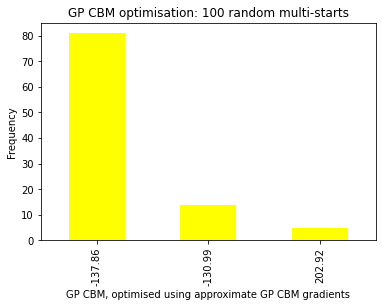

In [48]:
ax = gp_9_100rms.plot.bar(title="GP CBM optimisation: 100 random multi-starts", xlabel="GP CBM, optimised using approximate GP CBM gradients", ylabel="Frequency", color="yellow")


In [49]:
stp_9_100rms = pd.Series(np.round(stp_9_100rms.f_best, 2)).value_counts(sort=True)
stp_9_100rms_df = pd.DataFrame({'Frequency':stp_9_100rms.values,'STP CBM':stp_9_100rms.index})
stp_9_100rms_df


,Frequency,STP CBM
0,87,-1231.87
1,8,-1145.33
2,5,-423.16


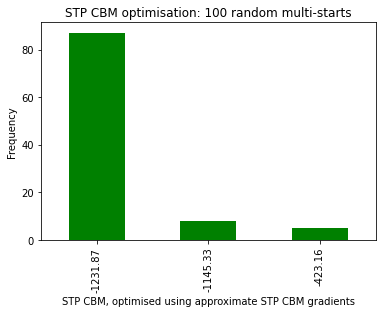

In [50]:
ax = stp_9_100rms.plot.bar(title="STP CBM optimisation: 100 random multi-starts", xlabel="STP CBM, optimised using approximate STP CBM gradients", ylabel="Frequency", color="green")


In [51]:
print(gp_9_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-137.86 &  17 \\
-130.99 &   2 \\
 202.92 &   1 \\
\bottomrule
\end{tabular}



In [52]:
print(stp_9_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-1231.87 &  17 \\
-1145.33 &   2 \\
-423.16  &   1 \\
\bottomrule
\end{tabular}



In [53]:
print(gp_9_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-137.86 &  38 \\
-130.99 &  10 \\
 202.92 &   2 \\
\bottomrule
\end{tabular}



In [54]:
print(stp_9_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-1231.87 &  43 \\
-1145.33 &   5 \\
-423.16  &   2 \\
\bottomrule
\end{tabular}



In [55]:
print(gp_9_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-137.86 &  81 \\
-130.99 &  14 \\
 202.92 &   5 \\
\bottomrule
\end{tabular}



In [56]:
print(stp_9_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-1231.87 &  87 \\
-1145.33 &   8 \\
-423.16  &   5 \\
\bottomrule
\end{tabular}

